In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from aqua.diagnostics.teleconnections import NAO, PlotNAO

/LUMI_TYKKY_L60Yfbf/miniconda/envs/env1/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [4]:
dataset_dict = {
    'catalog': 'climatedt-phase1',
    'model': 'IFS-NEMO',
    'exp': 'historical-1990',
    'source': 'lra-r100-monthly',
}
obs_dict = {
    'catalog': 'obs',
    'model': 'ERA5',
    'exp': 'era5',
    'source': 'monthly',
}
common_dict = {
    'loglevel': 'INFO'
}

In [5]:
nao_dataset = NAO(**dataset_dict, **common_dict)
nao_obs = NAO(**obs_dict, **common_dict)

In [6]:
nao_dataset.retrieve()
nao_obs.retrieve()

2025-05-14 18:13:27 :: ConfigPath :: INFO     -> IFS-NEMO_historical-1990_lra-r100-monthly triplet found in in climatedt-phase1!
2025-05-14 18:13:27 :: ConfigPath :: WARNING  -> No paths found in the main configuration file {'climatedt-phase1': {'catalog': ['climatedt-e25.1', 'mn5-phase2', 'nextgems4', 'lumi-phase2', 'lumi-phase1', 'climatedt-phase1', 'obs'], 'machine': 'lumi', 'reader': {'catalog': '/users/nurissom/.aqua/catalogs/climatedt-phase1/catalog.yaml', 'machine': '/users/nurissom/.aqua/catalogs/climatedt-phase1/machine.yaml', 'fixer': '/users/nurissom/.aqua/fixes', 'regrid': '/users/nurissom/.aqua/grids'}, 'options': {'style': 'aqua'}}}
2025-05-14 18:13:28 :: Reader :: INFO     -> Convention dictionary: eccodes-2.39.0
2025-05-14 18:13:28 :: Reader :: INFO     -> No fixer_name found, only convention will be applied
2025-05-14 18:13:28 :: Reader :: INFO     -> Grid metadata is lon-lat
2025-05-14 18:13:28 :: Regridder :: WARNING  -> Source grid path not found. Please provide a d

In [7]:
nao_dataset.compute_index()
nao_obs.compute_index()

In [8]:
reg_dataset = nao_dataset.compute_regression(season='DJF')
reg_obs = nao_obs.compute_regression(season='DJF')

In [9]:
plot = PlotNAO(loglevel='INFO', indexes=nao_dataset.index,
               ref_indexes=nao_obs.index)

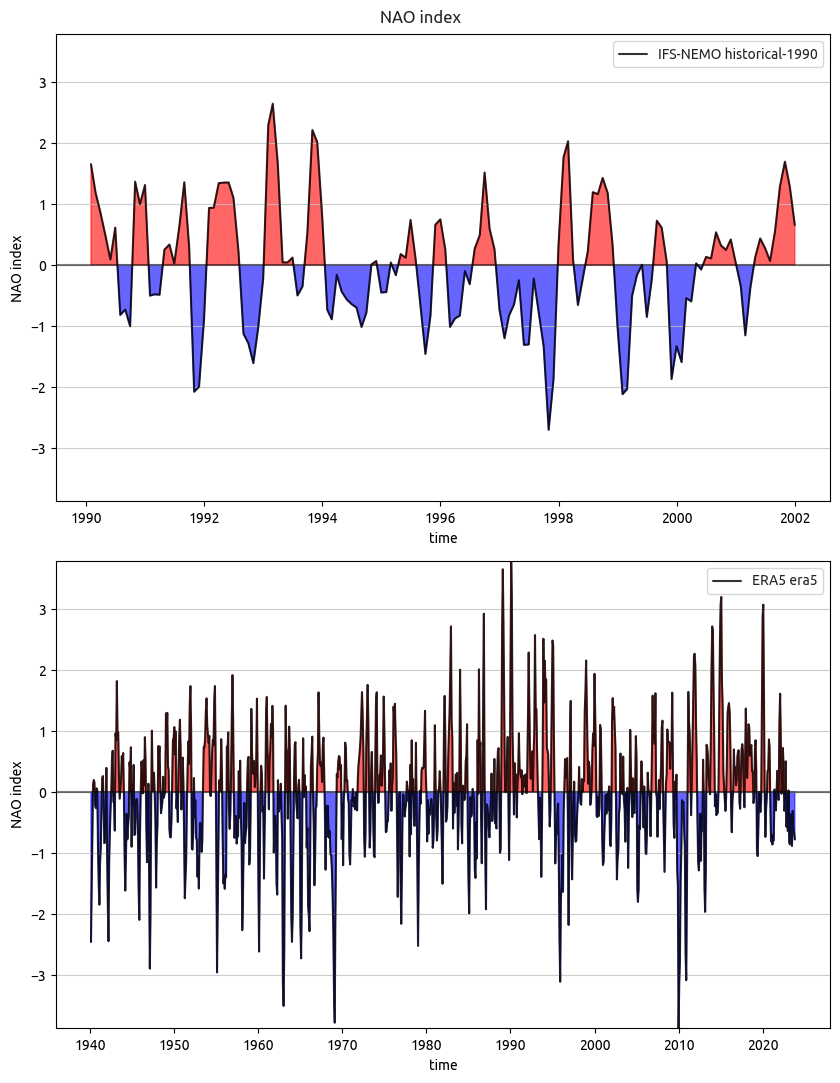

In [10]:
fig_index, _ = plot.plot_index()

In [11]:
reg_dataset.load()
reg_obs.load()

<xarray.DataArray (lat: 721, lon: 1440)> Size: 8MB
array([[ -47.05626144,  -47.05626144,  -47.05626144, ...,  -47.05626144,
         -47.05626144,  -47.05626144],
       [ -47.01276952,  -47.00805775,  -47.00460882, ...,  -47.02364339,
         -47.01870169,  -47.01850006],
       [ -46.9674877 ,  -46.96370626,  -46.95556324, ...,  -46.98441754,
         -46.97934142,  -46.97402476],
       ...,
       [-227.09557386, -227.09435701, -227.09207895, ..., -227.09802172,
        -227.09877164, -227.09717275],
       [-225.65112591, -225.64976756, -225.64801303, ..., -225.64985246,
        -225.64964022, -225.64941382],
       [-224.53995441, -224.53995441, -224.53995441, ..., -224.53995441,
        -224.53995441, -224.53995441]])
Coordinates:
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
Attributes: (12/14)
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Mean sea level pressure
    units:          Pa
    code:           151
    table:          128
    history:        \n2025-05-14 18:13:56 AQUA💧: Variable renamed msl from MS...
    ...             ...
    AQUA_model:     ERA5
    AQUA_exp:       era5
    AQUA_source:    monthly
    AQUA_catalog:   obs
    AQUA_version:   0.14.1-alpha
    AQUA_season:    DJF

2025-05-14 18:15:37 :: create_folder :: INFO     -> Folder ./png already exists
2025-05-14 18:15:38 :: add_png_metadata :: INFO     -> Metadata added to PNG: ./png/nao.regression.climatedt-phase1.IFS-NEMO.historical-1990.obs.ERA5.era5.png
2025-05-14 18:15:38 :: OutputSaver :: INFO     -> Saved PNG: ./png/nao.regression.climatedt-phase1.IFS-NEMO.historical-1990.obs.ERA5.era5.png


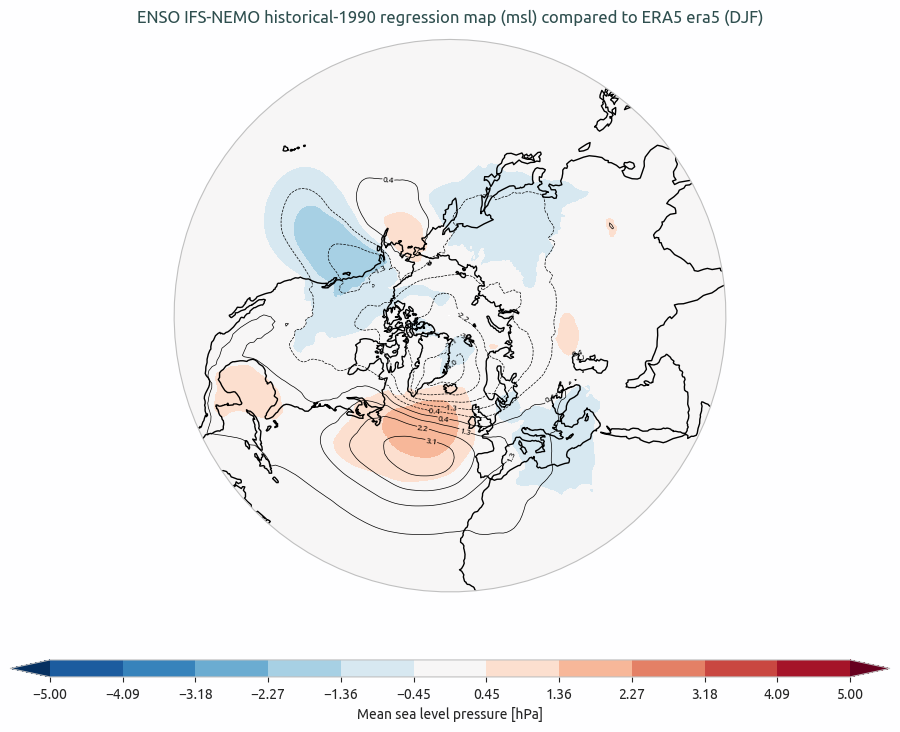

In [12]:
fig_reg = plot.plot_maps(maps=reg_dataset, ref_maps=reg_obs, statistic='regression')
description = plot.set_map_description(maps=reg_dataset, ref_maps=reg_obs, statistic='regression')
plot.save_plot(fig_reg, diagnostic_product='regression', metadata={'description': description})